# Bliss as a library

Bliss currently has not "server mode" so to directly control motors and acquisitions you need to use the Bliss API directly.

In [1]:
import os
import gevent
from bliss.data.scan import ScansWatcher, ScansObserver

/users/denolf/virtualenvs/bliss_jupyter/ubuntu_20_04/lib/python3.7/site-packages/tango/utils.py:181: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CmdArgType.DevString: numpy.str,


## Plot helper

Updateable matplotlib graphs

In [2]:
import matplotlib.pyplot as plt
from IPython import display

class Plotter:
    def __init__(self, max_plots=5):
        self.plots = list()
        self.fig = None
        self.max_plots = max_plots

    def update_plot_data(self, plot, label, x, y):
        if self.fig is None:
            self.fig, self.ax = plt.subplots(figsize=(10,6))
            self.hdisplay = display.display("", display_id=True)

        if plot is None:
            label = label.split(":")[-1]
            while label.startswith("_"):
                label = label[1:]
            plot = self.ax.plot(x, y, label=label)[0]
            self.plots.append(plot)
        else:
            plot.set_xdata(x)
            plot.set_ydata(y)

        self.update_display()
        return plot

    def update_display(self):
        if self.fig is None:
            return
        self.ax.relim()
        self.ax.autoscale()
        self.ax.legend()
        self.hdisplay.update(self.fig)

    def purge_plots(self):
        while len(self.plots) > self.max_plots:
            plot = self.plots.pop(0)
            plot.remove()
        self.update_display()

## Scan data watcher

A loop that runs forever and received all scan data related to a specific BLISS session

In [3]:
from contextlib import contextmanager

@contextmanager
def watch_scans_in_background(session_name):
    watcher = ScansWatcher(session_name)
    watcher.set_observer(ScanObserver(max_plots=3))

    print("Start data processing ...", flush=True)
    try:
        with watcher.watch():
            yield
    except KeyboardInterrupt:
        pass
    print("Data processing stopped", flush=True)

## Data processing

Plot data from "diode1".

In [4]:
import numpy

class ScanObserver(ScansObserver):
    def __init__(self, *args, max_plots=5, **kw):
        super().__init__(*args, **kw)
        self.scan_data = dict()
        self.plotter = Plotter(max_plots=max_plots)

    def on_scan_started(self, scan_db_name, scan_info):
        self.scan_data[scan_db_name] = {"data": [], "plot": None}
            
    def on_scan_finished(self, scan_db_name, scan_info):
        self.scan_data.pop(scan_db_name)
        self.plotter.purge_plots()

    def on_scalar_data_received(
        self, scan_db_name, channel_name, index, data_bunch
    ):
        if channel_name.endswith("diode1"):
            self.append_data(scan_db_name, "data", data_bunch)

    def append_data(self, scan_db_name, key, values):
        info = self.scan_data[scan_db_name]
        y = info[key] = numpy.append(info[key], values)
        x = numpy.arange(y.size)
        info["plot"] = self.plotter.update_plot_data(
                info["plot"], scan_db_name, x, y
            )

## Initialize a Bliss session in the local process

In [5]:
from bliss.config import static

os.environ["BEACON_HOST"] = "localhost:10001"
os.environ["TANGO_HOST"] = "localhost:10000"

config = static.get_config()
bliss_session = config.get("demo_session")
assert bliss_session.setup(), "Session setup failed"
bliss_objects = bliss_session.env_dict

                                                                                  
demo_session: Executing setup file...

Welcome to your new 'demo_session' BLISS session !!

You have a 1mm x 1mm sample mounted on a sample stage that can be moved with sy and sz

Some ideas for scans:

- amesh(sy,-.75,.75,30,sz,-.75,.75,30,.001,fluo_diode)
- amesh(sy,-.1,.1,20,sz,-.3,0,30,.001,fluo_diode)
- umv(slit_vertical_gap,.1);ascan(slit_vertical_offset,-1,1,30,.1,beamviewer)
- timescan(1, tomocam)
- timescan(1, diffcam)
- timescan(1, mca1)
- regulation.plot();sleep(1);regulation.setpoint=10
- s=simu_l2scan(robx,20,85,100,roby,50,110,30,0.01, simdatapath='${DEMO_ROOT}/../tests/images/bliss_logo.png', scale=1)

Slits are fully open when slit_top=10 and slit_bottom=10
Slits are not aligned, yet!




## Perform an experiment

Start data processing ...


/home/denolf/dev/bliss/bliss/common/motor_group.py:190: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(d, collections.Mapping):


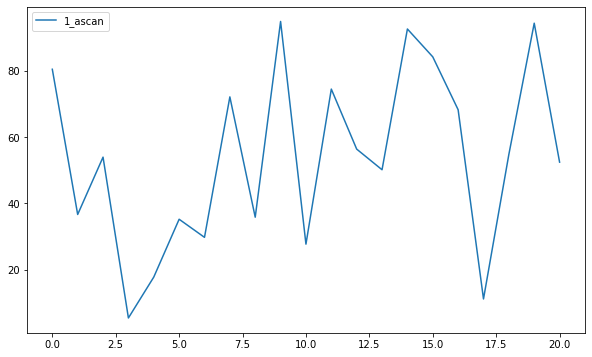

Data processing stopped


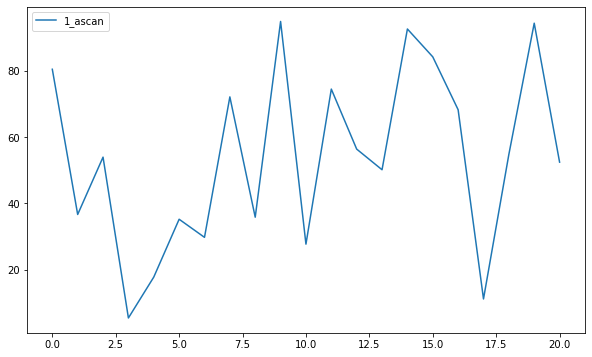

In [6]:
from bliss.common.standard import mv
from bliss.common.scans import ascan

with watch_scans_in_background(bliss_session.name):
    slit_vertical_offset = bliss_objects["slit_vertical_offset"]
    diode1 = bliss_objects["diode1"]

    ascan(slit_vertical_offset, -2, 2, 20, 0.01, diode1, save=False)
    mv(slit_vertical_offset, 3)
    assert slit_vertical_offset.position == 3